E-commerce Problem Statement

Amazon is an online shopping website that now caters to millions of people everywhere. Over 34,000 consumer reviews for Amazon brand products like Kindle, Fire TV Stick and more are provided. 
The dataset has attributes like brand, categories, primary categories, reviews.title, reviews.text, and the sentiment. Sentiment is a categorical variable with three levels "Positive", "Negative“, and "Neutral". For a given unseen data, the sentiment needs to be predicted.
You are required to predict Sentiment or Satisfaction of a purchase based on multiple features and review text.

In [ ]:
# Import required libraries
# Import the TensorFlow library
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import re
import matplotlib.pylab as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost 
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import keras_tuner as kt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF


: 

We first read the csv file and check which features can be used to predict customers sentiments. Upon analysing the features and their data, we come to conclusion that only review.text and review.title have direct relation to customer sentiment. Therefore only this feature will be used as input features. We merge this two features into 1 review.text.
Next we perform an EDA on the dataset and pre-process the review.text input feature. Then we print to see what a positive, negative, and neutral review looks like.
And also we check the class count for each class to show class imbalance, that can lead to overfitting of algorithms.

Training dataframe:
                                                    name   brand  \
0     All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...  Amazon   
1           Amazon - Echo Plus w/ Built-In Hub - Silver  Amazon   
2     Amazon Echo Show Alexa-enabled Bluetooth Speak...  Amazon   
3     Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...  Amazon   
4     Brand New Amazon Kindle Fire 16gb 7" Ips Displ...  Amazon   
...                                                 ...     ...   
3995        Amazon - Echo Plus w/ Built-In Hub - Silver  Amazon   
3996  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
3997  Amazon Tap - Alexa-Enabled Portable Bluetooth ...  Amazon   
3998  Brand New Amazon Kindle Fire 16gb 7" Ips Displ...  Amazon   
3999  All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...  Amazon   

                                             categories  \
0     Electronics,iPad & Tablets,All Tablets,Fire Ta...   
1     Amazon Echo,Smart Home,Networking,Home & Tools... 

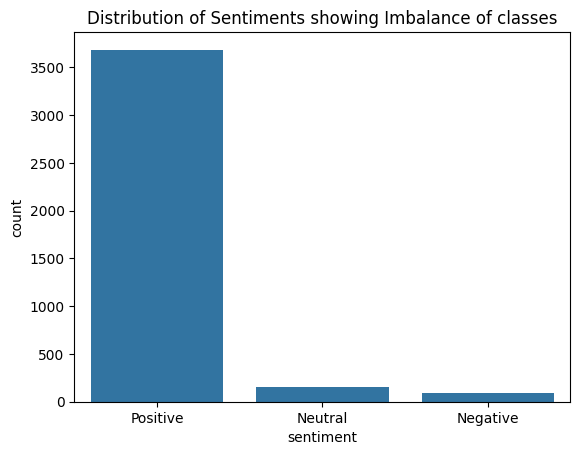

Positive Review Example: powerful tablet purchased black fridaypros great price even sale powerful fast quad core processors amazing soundwell builtcons ads amazon need subsidize tablet remove adds pay access apps except ones amazon way able accomplish add google play storenet great tablet money
Neutral Review Example: average average alexa option show things screen still limited
Negative Review Example: cheap run chrome stuff returned cheap run chrome stuff returned store


In [326]:
# importing the data files using pandas.read_csv reads the csv file 
rawIdata = pd.read_csv('train_data.csv') # training dataset
rawVdata = pd.read_csv('test_data_hidden.csv') # Validation dataset
print('Training dataframe:\n',rawIdata)

# Check for missing, null and duplicate values 
print('Columns with Null values:')
print(rawIdata.isnull().sum())
print('Columns with N\A values:')
print(rawIdata.isna().sum())
print('Columns with duplicated values:')
print(rawIdata.duplicated().sum())

#  Clean the data by removing or correcting any errors
rawIdata.drop_duplicates(inplace=True)
rawIdata.dropna(inplace=True)
rawVdata.drop_duplicates(inplace=True)
rawVdata.dropna(inplace=True)

# Merging reviews.titel and reviews.text into a new column reviews.text
gap = ' '
rawIdata['reviews.text'] = rawIdata['reviews.title'] + gap + rawIdata['reviews.text'] 
print('Training datafram with merged text and title columns:\n',rawIdata)
rawVdata['reviews.text'] = rawVdata['reviews.title'] + gap + rawVdata['reviews.text'] 

# Data Cleaning for training and evaluation datasets
# Normalise the casing of the review text
rawIdata['reviews.text'] = rawIdata['reviews.text'].str.lower()
rawVdata['reviews.text'] = rawVdata['reviews.text'].str.lower()

# Normalise terms with dilect characters. NFKD is a normalisation form that splits the base character from its diacritic and then converts it into ascii.
rawIdata['reviews.text'] = rawIdata['reviews.text'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
rawVdata['reviews.text'] = rawVdata['reviews.text'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Removing user handles starting with @
rawIdata['reviews.text'] = rawIdata['reviews.text'].replace(r'@\w+', '', regex=True)
rawVdata['reviews.text'] = rawVdata['reviews.text'].replace(r'@\w+', '', regex=True)

# Removing URLs
rawIdata['reviews.text']= rawIdata['reviews.text'].replace(r'http\S+', '', regex=True)
rawVdata['reviews.text']= rawVdata['reviews.text'].replace(r'http\S+', '', regex=True)

# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
rawIdata['reviews.text'] = [lemmatizer.lemmatize(token) for token in rawIdata['reviews.text']]
rawVdata['reviews.text'] = [lemmatizer.lemmatize(token) for token in rawVdata['reviews.text']]

# Using word Tokenizer from NLTK, tokenize the reviews into individual terms
def Tokenize(text):
    tokenizer = word_tokenize(text)
    return tokenizer

rawIdata['reviews.text'] = rawIdata['reviews.text'].apply(Tokenize)
rawVdata['reviews.text'] = rawVdata['reviews.text'].apply(Tokenize)

# Remove english stopwords and additional words like amp, rt, etc. from the reviews using NLTK stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['amp', 'rt', 'via', 'retweet','ur', 'u', 'w', 'b', 'c', 'im', 'dont', 'cant', 'thats', 'wont', 'isnt', 'didnt', 'couldnt', 'wouldnt'])
rawIdata['reviews.text'] = rawIdata['reviews.text'].apply(lambda x: [item for item in x if not item in stop_words])
rawVdata['reviews.text'] = rawVdata['reviews.text'].apply(lambda x: [item for item in x if not item in stop_words])

# Remove punctuation, special characters and numbers from the review terms
rawIdata['reviews.text'] = rawIdata['reviews.text'].apply(lambda x: [item for item in x if item.isalpha()])
rawVdata['reviews.text'] = rawVdata['reviews.text'].apply(lambda x: [item for item in x if item.isalpha()])

# Removing terms with a length of 1
rawIdata['reviews.text'] = rawIdata['reviews.text'].apply(lambda x: [item for item in x if len(item) > 1])
rawVdata['reviews.text'] = rawVdata['reviews.text'].apply(lambda x: [item for item in x if len(item) > 1])

# Pritning the first 5 preprocessed tweets
print('The first 5 preprocessed tweets are:\n',rawIdata['reviews.text'].head())

# Data formatting for predictive modeling
# Convert the tokenized reviews back into a single string
rawIdata['reviews.text'] = rawIdata['reviews.text'].apply(lambda x: ' '.join(x))
rawVdata['reviews.text'] = rawVdata['reviews.text'].apply(lambda x: ' '.join(x))

# Reseting the row index to start numbering from 0
rawIdata.reset_index(drop=True, inplace=True) 
CleanIdata =rawIdata
print('New dataframe after cleaning dataset:\n',CleanIdata)
# Same is done for evaluation dataset
rawVdata.reset_index(drop=True, inplace=True) 
CleanVdata =rawVdata

# Distribution of sentiment classes for training dataset
sns.countplot(x='sentiment', data=CleanIdata)
plt.title('Distribution of Sentiments showing Imbalance of classes')
plt.show()

# Examples of each sentiment class
positive_review = CleanIdata[CleanIdata['sentiment'] == 'Positive']['reviews.text'].iloc[0]
neutral_review = CleanIdata[CleanIdata['sentiment'] == 'Neutral']['reviews.text'].iloc[0]
negative_review = CleanIdata[CleanIdata['sentiment'] == 'Negative']['reviews.text'].iloc[0]

# Review examples
print(f"Positive Review Example: {positive_review}")
print(f"Neutral Review Example: {neutral_review}")
print(f"Negative Review Example: {negative_review}")

Now we convert the reviews.text inpit feature in Tf-Idf score and label encode the target feature sentiments as integer classes. We create data for training and testing.
Next we run multinomial Naive Bayes classifier on this data. The model predicts with high accuracy, however shows 0 f1 score fot negative and neutral class, as seen from the classification report and confusion matrix. Therefore, the assumtions made for algorithms will overfit is true.

New TF-IDF scored array for input text feature:
  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Label encoded target column:
 0       2
1       2
2       1
3       2
4       2
       ..
3927    2
3928    2
3929    2
3930    2
3931    2
Name: sentiment_label, Length: 3932, dtype: int32
Encoded classes are:  ['Negative' 'Neutral' 'Positive']
Classes Encoded with labels as:  ['Negative' 'Neutral' 'Positive']  and are corresponding to the Sentiments:  [0 1 2] respectively.
Predictions of Multinomial NB classifier on imbalanced dataset:
        Actual  Labled_A Predicted  Labled_P
0    Positive         2  Positive         2
1    Positive         2  Positive         2
2    Positive         2  Positive         2
3    Positive         2  Positive         2
4    Positive         2  Positive         2
..        ...       ...       ...       ...
989  Positive         2  Positive         2

c:\Users\rynem\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rynem\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rynem\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


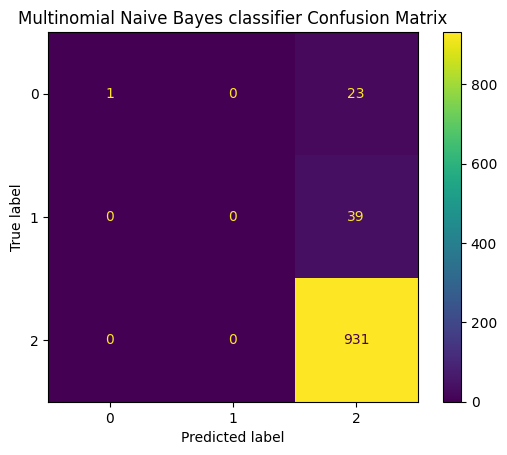

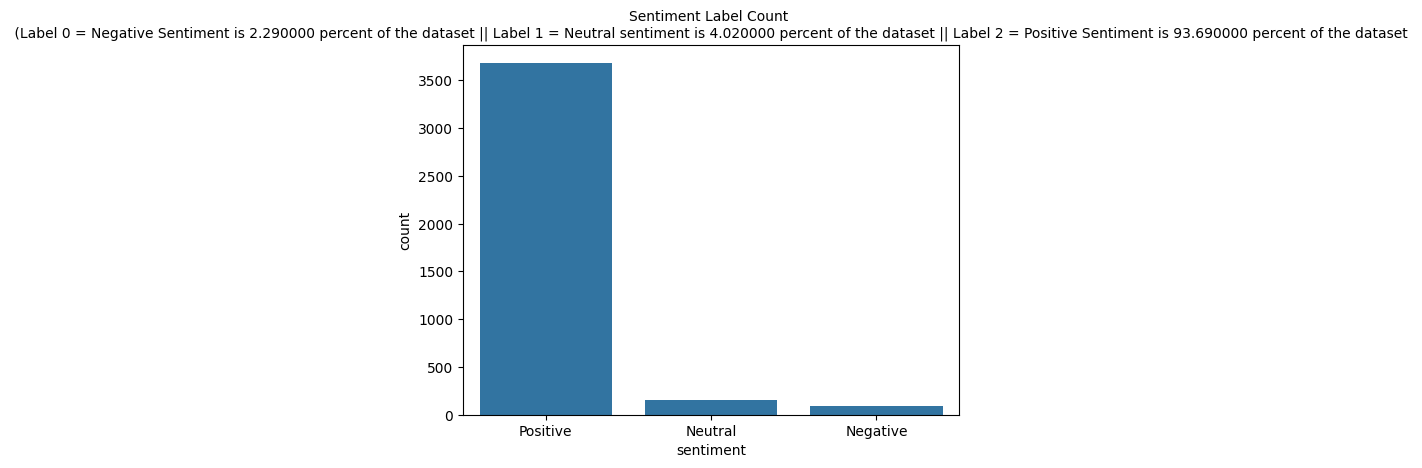

In [327]:
# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english', strip_accents='unicode')

# Fit and transform the text data
X = tfidf.fit_transform(CleanIdata['reviews.text'].fillna('')).toarray()
print('New TF-IDF scored array for input text feature:\n ',X)
df = pd.DataFrame(X) # Creating a dataframe for later use of merging with sentiment score
XV = tfidf.transform(CleanVdata['reviews.text'].fillna('')).toarray()
dfV = pd.DataFrame(XV)

# Convert the sentiment labels to numerical values
le = LabelEncoder()
CleanIdata['sentiment_label'] = le.fit_transform(CleanIdata['sentiment'])
print('Label encoded target column:\n',CleanIdata['sentiment_label'])
print('Encoded classes are: ',le.classes_)
print('Classes Encoded with labels as: ',le.inverse_transform([0,1,2]),' and are corresponding to the Sentiments: ',le.transform(['Negative' ,'Neutral', 'Positive']), 'respectively.')

# for Evaluation data
CleanVdata['sentiment_label'] = le.transform(CleanVdata['sentiment'])

# Create training and test sets
X_train, X_test, y_train, y_test = X, XV, CleanIdata['sentiment_label'], CleanVdata['sentiment_label']

# Initialize and train the model on multinomial Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test)
Result = pd.DataFrame({'Actual': le.inverse_transform(y_test), 'Labled_A' : y_test, 'Predicted': le.inverse_transform(y_pred) , 'Labled_P' : y_pred})
print('Predictions of Multinomial NB classifier on imbalanced dataset:\n',Result)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.title('Multinomial Naive Bayes classifier Confusion Matrix')
plt.show()

# Since the f1 score is low for Neutral and Negative classes, implying minority class shown in classificqation report, and the confusion matrix shows all test data was predicted as positive therefore class imbalance
# This can be further confimed by the countplot of the target variable
# Checking for imbalances in target by checking total sentiment count
Pos =  round(CleanIdata['sentiment'].value_counts()["Positive"]/len(CleanIdata) * 100,2)
Neg =  round(CleanIdata['sentiment'].value_counts()["Negative"]/len(CleanIdata) * 100,2)
Neu =  round(CleanIdata['sentiment'].value_counts()["Neutral"]/len(CleanIdata) * 100,2)

# Plotting the target variable to check for imbalances
sns.countplot(x='sentiment', data=CleanIdata)
plt.title('Sentiment Label Count \n (Label 0 = Negative Sentiment is %f percent of the dataset || Label 1 = Neutral sentiment is %f percent of the dataset || Label 2 = Positive Sentiment is %f percent of the dataset ' % (Neg, Neu, Pos) ,fontsize=10)
plt.xticks(range(3), ["Positive","Neutral", "Negative"])
plt.show()




Now we use Oversampling to tackle the class imbalance problem and Run the Multinomial NB classifier on the new oversampled training dataset. Furtheremore, we will use the following metrices for evaluating model performance: precision, recall, F1-score, AUC-ROC curve. And F1-Score as the evaluation criteria for this project from the classification report. The new model does give some improvements for f1 score for minority but its very less for mulitnomial NB.

Shape of the new oversmapled and undersampled dataset for features : (11052, 5000) and target: (11052,)
Original dataset shape Counter({2: 3684, 1: 158, 0: 90})
Resampled dataset shape Counter({2: 3684, 1: 3684, 0: 3684})
Predictions of Multinomial NB classifier on balanced dataset:
        Actual  Labled_A Predicted  Labled_P
0    Positive         2  Positive         2
1    Positive         2  Positive         2
2    Positive         2  Positive         2
3    Positive         2  Positive         2
4    Positive         2  Positive         2
..        ...       ...       ...       ...
989  Positive         2  Positive         2
990   Neutral         1  Positive         2
991  Positive         2  Positive         2
992  Positive         2  Negative         0
993  Positive         2  Positive         2

[994 rows x 4 columns]
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.54      0.42        24
           1       0.24      0

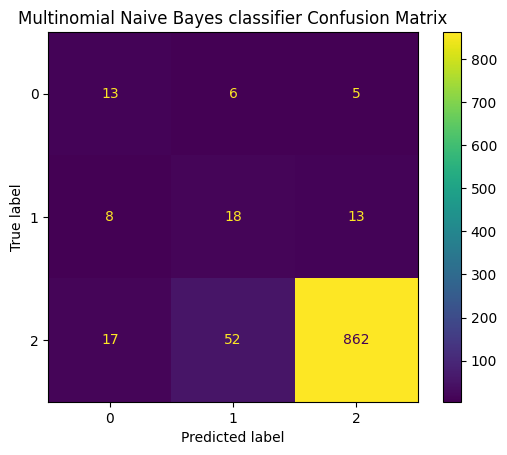

In [328]:
# Since the target variable is imbalanced for minorities, we can use SMOTE to balance the target variable
# Applying Oversampling on training dataset to balance the target variable using SMOTE
# SMOTE method applies SMOTE to oversample the minority calss with synthetic new data 

SN = SMOTE() # using SMOTE to create an object nm3
x_samples,y_samples= SN.fit_resample(X_train, y_train)    # fit and transform the training data
print('Shape of the new oversmapled and undersampled dataset for features :'  , x_samples.shape, 'and target:',y_samples.shape)     # print the shape of the new dataset
print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_samples)))

# Checking if SMOTE helped
# Initialize and train the model on multinomial Naive Bayes classifier for oversmapled trainig data
nb = MultinomialNB()
nb.fit(x_samples, y_samples)

# Make predictions on the test set
NBy_pred = nb.predict(X_test)
NBy_pred_prob = nb.predict_proba(X_test) # Used later to cobine with XGB probabilities 
Result = pd.DataFrame({'Actual': le.inverse_transform(y_test), 'Labled_A' : y_test, 'Predicted': le.inverse_transform(NBy_pred) , 'Labled_P' : NBy_pred})
print('Predictions of Multinomial NB classifier on balanced dataset:\n',Result)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, NBy_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, NBy_pred)).plot()
plt.title('Multinomial Naive Bayes classifier Confusion Matrix')
plt.show()

Now using Tree-based classifiers like Random Forest and XGBoost for classifiying sentiments. Insted of using the balanced (SMOTE oversampled) dataset used previously, we use Random forest and XGB boost inbuild parameters like sample weights, to balance the dataset during training. This gives us a better performing prediction model of Random forest (RF) with better scores than multinomial NB. However, XG boost fails to get similar results as RF and performs worse than NB. 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400building tree 42 of 400

b

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.9s


building tree 158 of 400building tree 159 of 400

building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:    2.5s


building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.0s finished


The accuracy score for Random Forest is: 95.4728370221328
The classification report for Random Forest is:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50        24
           1       1.00      0.26      0.41        39
           2       0.95      1.00      0.98       931

    accuracy                           0.95       994
   macro avg       0.98      0.53      0.63       994
weighted avg       0.96      0.95      0.94       994

The accuracy score for XGBoost is: 80.08048289738431
The classification report for XGBoost is:
               precision    recall  f1-score   support

           0       0.11      0.58      0.19        24
           1       0.20      0.44      0.27        39
           2       0.98      0.82      0.89       931

    accuracy                           0.80       994
   macro avg       0.43      0.61      0.45       994
weighted avg       0.93      0.80      0.85       994



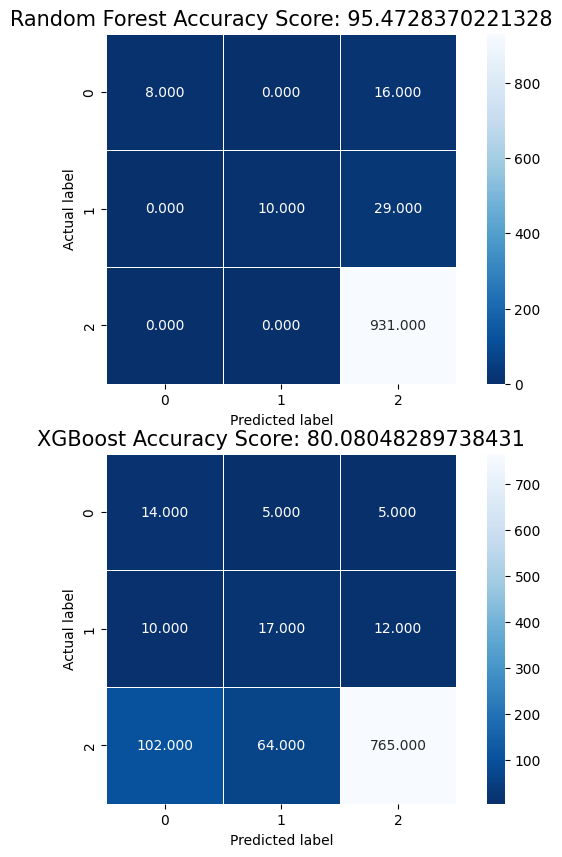

In [329]:
# Computing sample weights for each row using count of y_train for overcoming the class imbalance
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
# Creating Random forrst anf XG boos classifiers 
RF = RandomForestClassifier(class_weight='balanced_subsample' ,verbose=2, n_estimators=400, n_jobs=-1, random_state=42) # Class_weight is used to balance the target variable while sampling during bagging 
XGB = XGBClassifier( tree_method="hist", device="cuda", n_estimators=400, n_jobs=-1, learning_rate=0.01, objective='multi:softmax', verbosity=2, use_label_encoder=False)


# fit model for Random Forest and XGBoost
RF.fit(X_train,y_train, sample_weight = sample_weights)
XGB.fit(X_train,y_train, sample_weight = sample_weights)


# Predict the target variable for the test data
RFy_pred = RF.predict(X_test)
XGBy_pred = XGB.predict(X_test)

# Calculate the accuracy score and  classification report for the models that shows f1 score, precision, recall and support for Random Forest and XGBoost
print('The accuracy score for Random Forest is:', accuracy_score(y_test,RFy_pred)*100)
print('The classification report for Random Forest is:\n',classification_report(y_test,RFy_pred))
print('The accuracy score for XGBoost is:', accuracy_score(y_test,XGBy_pred)*100)
print('The classification report for XGBoost is:\n',classification_report(y_test,XGBy_pred))

# Create a confusion matrix for Random Forest and XGBoost
RF_cm = confusion_matrix(y_test, RFy_pred)
XGB_cm = confusion_matrix(y_test, XGBy_pred)

# Plot the confusion matrix for Random Forest and XGBoost
i=0
plt.figure(figsize=(8, 10))
for i in range(2):
    if i == 0:
        cm = RF_cm
        y_pred = RFy_pred
        title = 'Random Forest '
    elif i == 1:
        cm = XGB_cm
        y_pred = XGBy_pred
        title = 'XGBoost '
    plt.subplot(2,1,i+1)
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred)*100)
    plt.title(title+all_sample_title, size = 15)
    i += 1
plt.show()

Applying multi-class SVM’s (SVC) on imbalaced datset and using parameter like sample weight and class weights used previously to overcome class imbalace. Applying neural nets in the form of a simple Neural network with single hidden layer on SMOTE sampled dataset.Next, we use ensemble techniques like Voting classfier to combine XGboost and oversampled_multinomial_NB to find a better performing overall model since these two models performed poorly. Upon training all thses different models the SVM performed the best with respect to each class f1 score, followed by simple neural network that converged after just 10 interations. Lasttly, the ensembles XGB and NB performed similarly to neural network but performed better than their base models that performed individually.

SVM with Balanced Class Weight - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.33      0.48        24
           1       0.68      0.33      0.45        39
           2       0.96      1.00      0.98       931

    accuracy                           0.95       994
   macro avg       0.84      0.55      0.64       994
weighted avg       0.95      0.95      0.95       994



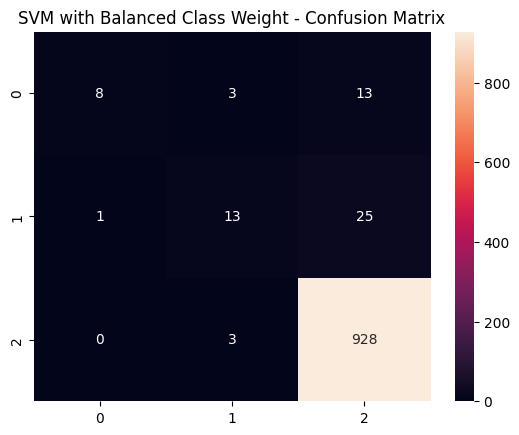

Iteration 1, loss = 0.13272771
Iteration 2, loss = 0.00296774
Iteration 3, loss = 0.00186187
Iteration 4, loss = 0.00160055
Iteration 5, loss = 0.00146250
Iteration 6, loss = 0.00135655
Iteration 7, loss = 0.00126612
Iteration 8, loss = 0.00118796
Iteration 9, loss = 0.00111591
Iteration 10, loss = 0.00105236
Iteration 11, loss = 0.00099602
Iteration 12, loss = 0.00094246
Iteration 13, loss = 0.00089297
Iteration 14, loss = 0.00084808
Iteration 15, loss = 0.00081097
Iteration 16, loss = 0.00077514
Iteration 17, loss = 0.00073908
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Classification Report (Neural Network):
              precision    recall  f1-score   support

           0       0.65      0.46      0.54        24
           1       0.44      0.31      0.36        39
           2       0.97      0.99      0.98       931

    accuracy                           0.95       994
   macro avg       0.69      0.58      0.63       994
weighted 

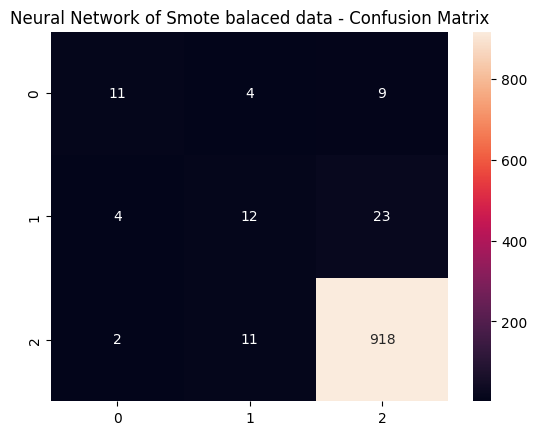

Classification Report (Ensemble Model):
              precision    recall  f1-score   support

           0       0.43      0.54      0.48        24
           1       0.34      0.41      0.37        39
           2       0.98      0.96      0.97       931

    accuracy                           0.93       994
   macro avg       0.58      0.64      0.61       994
weighted avg       0.94      0.93      0.93       994



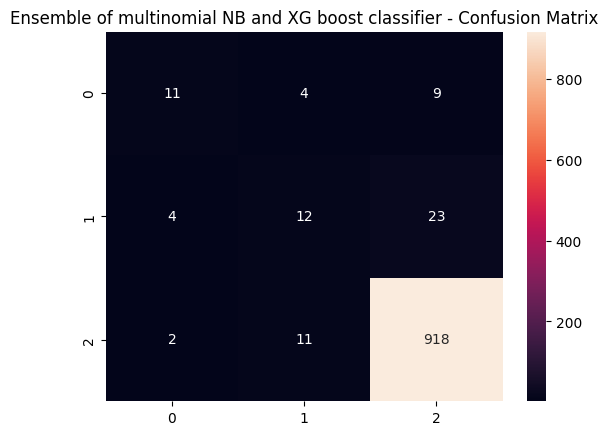

In [330]:
# SVM with class_weight balanced
svm_balanced = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_balanced.fit(X_train,y_train, sample_weight=sample_weights)
y_pred_svm_balanced = svm_balanced.predict(X_test)

# Evaluation
print("SVM with Balanced Class Weight - Classification Report:\n", classification_report(y_test, y_pred_svm_balanced))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_balanced), annot=True, fmt='d')
plt.title('SVM with Balanced Class Weight - Confusion Matrix')
plt.show()


# Train a simple Neural Network (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42,activation='relu', solver='adam', alpha=0.0001, batch_size=128, learning_rate='adaptive', learning_rate_init=0.01, verbose=1)
mlp_model.fit(x_samples,y_samples)

# Predict using Neural Network
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate Neural Network
print("Classification Report (Neural Network):")
print(classification_report(y_test, y_pred_mlp))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d')
plt.title('Neural Network of Smote balaced data - Confusion Matrix')
plt.show()

# Ensemble: XGBoost + Multinomial Naive Bayes (Oversampled)
ensemble_model = VotingClassifier(estimators=[('xgb', XGB),('nb', nb)],voting='soft')

# Train the ensemble model
ensemble_model.fit(x_samples,y_samples)

# Predict using ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate Ensemble Model
print("Classification Report (Ensemble Model):")
print(classification_report(y_test, y_pred_ensemble))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d')
plt.title('Ensemble of multinomial NB and XG boost classifier - Confusion Matrix')
plt.show()

Assigning a score to the sentence sentiment and creating afeature called sentiment score. Moreover, we will use this engineered feature along with review.text and check for improvements. We use sentiment intensity analyzer from VADER that uses highly optimised dictionary called Lexicon to score each data sample text from -1 to 1 baesed on sentiments score in the library. We use this to create a new input varible of sentiment score that will be used along with text.review as input dataset. We will also use RF classfier to see if this increase the f1 score performance for minority class. However, these does give a the same result we got for RF model without sentiment score.

  sentiment  sentiment_score
0  Positive           0.9744
1  Positive           0.9747
2   Neutral          -0.2263
3  Positive           0.7003
4  Positive           0.4404
[[ 0.      0.      0.     ...  0.      0.      0.9744]
 [ 0.      0.      0.     ...  0.      0.      0.9747]
 [ 0.      0.      0.     ...  0.      0.     -0.2263]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.1027]
 [ 0.      0.      0.     ...  0.      0.      0.875 ]
 [ 0.      0.      0.     ...  0.      0.      0.6808]]
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 26 of 400building tree 27 of 400

building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400


[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:    1.3s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.0s finished


RF with Sentiment Score - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50        24
           1       1.00      0.26      0.41        39
           2       0.95      1.00      0.98       931

    accuracy                           0.95       994
   macro avg       0.98      0.53      0.63       994
weighted avg       0.96      0.95      0.94       994



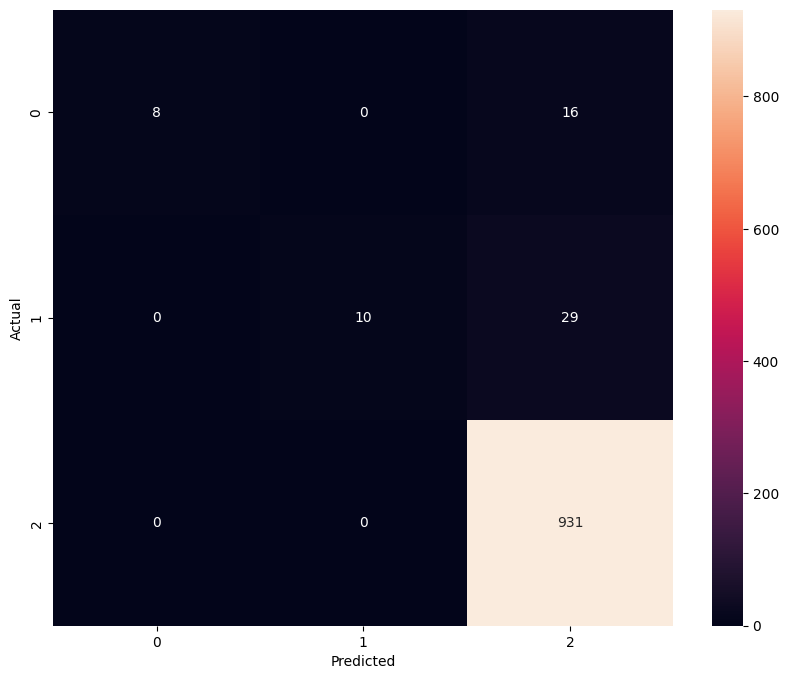

In [331]:
# Initialize the VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment score using VADER
def Sentiment_score(text):
    score = analyzer.polarity_scores(text)
    # The compound score is a normalized score between -1 (negative) and 1 (positive)
    return score['compound']

# Apply function on the review.txt
CleanIdata['sentiment_score'] = CleanIdata['reviews.text'].apply(Sentiment_score)
CleanVdata['sentiment_score'] = CleanVdata['reviews.text'].apply(Sentiment_score)

# Check the dataframe to ensure the feature is created
print(CleanIdata[['sentiment', 'sentiment_score']].head())

# Using Sentiment score to train the model
# Combine the sentiment score with the TF-IDF features 
X_with_score = np.array(pd.concat([df,CleanIdata['sentiment_score']], axis=1))
XV_with_score = np.array(pd.concat([dfV,CleanVdata['sentiment_score']], axis=1))
print(X_with_score)

# Split the data into training and test sets
X_train_with_score, X_test_with_score, y_train, y_test = X_with_score,  XV_with_score, CleanIdata['sentiment_label'], CleanVdata['sentiment_label']

# Computing sample weigths and creating Rf model
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
RF = RandomForestClassifier(class_weight='balanced_subsample' ,verbose=2, n_estimators=400, n_jobs=-1, random_state=42) # Class_weight is used to balance the target variable while sampling during bagging 

# fit model for Random Forest and XGBoost
RF.fit(X_train_with_score,y_train, sample_weight = sample_weights)

# Evaluate the model
# Predict the target variable for the test data
y_pred_with_score_RF = RF.predict(X_test_with_score)
print("RF with Sentiment Score - Classification Report:\n", classification_report(y_test, y_pred_with_score_RF))
# Confusion matrix 
cm = tf.math.confusion_matrix(y_test, y_pred_with_score_RF) 
    
# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

Using recurrent networks like LTSM and GRU on the previous problems.  we begins by preprocessing the text data to build the vocabulary dynamically, converting it into a numerical format suitable for the keras neural network. Moreover, we also one hot enocde the categorical target variable data. Then, an LSTM model is constructed, incorporating layers for embedding, processing sequential information using LTSM layer, and making predictions. The model is trained on the preprocessed data that we have taken sample weights for, and its performance is evaluated using metrics like f1score and confusion matrices. 

We 

Tonkenized matrix of text review:
 [[   0    0    0 ...    1    2  110]
 [   0    0    0 ... 1026  105   82]
 [   0    0    0 ...   19   74  484]
 ...
 [   0    0    0 ...  323 2697  259]
 [   0    0    0 ...   67 1237  486]
 [   0    0    0 ...    2  134 1729]]
One hot encoded sentiments target column:
       Negative  Neutral  Positive
0        False    False      True
1        False    False      True
2        False     True     False
3        False    False      True
4        False    False      True
...        ...      ...       ...
3927     False    False      True
3928     False    False      True
3929     False    False      True
3930     False    False      True
3931     False    False      True

[3932 rows x 3 columns]
(3932, 100) (3932, 3)
(3145, 100) (787, 100) (3145, 3) (787, 3)
Reloading Tuner from v1\RandomSearch\tuner0.json
Results summary
Results in v1\RandomSearch
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 09 summary
Hyperparameters:
act

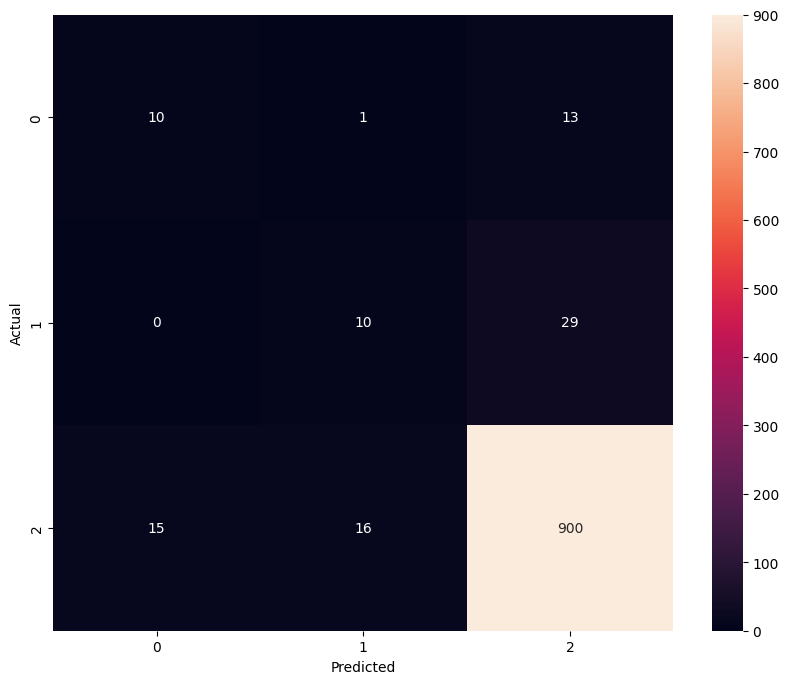

              precision    recall  f1-score   support

           0       0.40      0.42      0.41        24
           1       0.37      0.26      0.30        39
           2       0.96      0.97      0.96       931

    accuracy                           0.93       994
   macro avg       0.58      0.55      0.56       994
weighted avg       0.92      0.93      0.92       994



In [336]:
# Creating tokenixer instace and initialising max words for the input dataset
tokenizer = Tokenizer() 
max_words = 100  
# converting all the reviews to list to pass it as a parameter to fit_on_texts 
reviews_to_list = CleanIdata['reviews.text'].fillna('').tolist() 
# Creating a vocablary from the text
tokenizer.fit_on_texts(reviews_to_list) 
# Generating text sequences 
X_seq = tokenizer.texts_to_sequences(reviews_to_list)
# Generatin our X (input) to the model 
text_sequences = np.array(X_seq, dtype="object") 

# using pad_sequences
X = pad_sequences(text_sequences, maxlen = max_words) 
print('Tonkenized matrix of text review:\n',X)

# for Evaluation data
# Generating text sequences 
XV_seq = tokenizer.texts_to_sequences(CleanVdata['reviews.text'].fillna('').tolist())
# Generatin our X (input) to the model 
textV_sequences = np.array(XV_seq, dtype="object") 
# using pad_sequences
XV = pad_sequences(textV_sequences, maxlen = max_words) 

# one hot encoding training data target variable
y = pd.get_dummies(CleanIdata['sentiment']) 
print('One hot encoded sentiments target column:\n',y)
print(X.shape, y.shape)

# for evaluation data
yV = pd.get_dummies(CleanVdata['sentiment']) 

# Spliting datset for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.20, random_state=42) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# We perform normalisation and regularization withing the model suing Batch normalization and dropout layers, respectively.
# we create a sequenttial model that haa a input pre processing layer of embeddings for turning our positive integers (indexes) into dense vectors of fixed size.
# Define the LSTM model

# Defining a custome ANN model for hyperparameter tuning. The model will have 1 input layer, 1-3 hidden layer and 1 output layer
# The model will be compiled with different hyperparameters like activation function, optimizer, learning rate, dropout and number of hidden layers
def build_model(hp):
    active_func = hp.Choice('activation', ['relu', 'tanh'])
    optimizer = hp.Choice('optimizer', ['adam', 'RMSprop'])
    lstm_units = hp.Int('lstm_units', min_value=50, max_value=200, sampling= 'linear',step=50)
    lr = hp.Float('learning_rate', min_value=0.0001, max_value=0.1, sampling='log', step=10)
    drop = hp.Float('dropout', min_value=0.2, max_value=0.7, sampling= 'linear',step=0.1)

    # create model
    model = Sequential(name="LSTM_Model")
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=max_words, input_length=max_words))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False, activation=active_func)))
    model.add(BatchNormalization())
    model.add(Dropout(drop))
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop))
    model.add(Dense(3, activation='softmax'))
    
    # compile the model choosing the optimizer and learning rate
    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        raise("Not supported optimizer")
        
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model


tuner = kt.RandomSearch(build_model, objective=kt.Objective('val_loss', direction='min'), max_trials=10, executions_per_trial=2, project_name="RandomSearch", directory="v1")

# Define the early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20, restore_best_weights=True, verbose=1, mode='min')
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Search for the best hyperparameters
tuner.search(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, y_test), sample_weight=sample_weights)
print(tuner.results_summary())
print('The best hyperparameters are:\n',tuner.get_best_hyperparameters()[0].values)
best_model = build_model(tuner.get_best_hyperparameters(1)[0])
best_model.summary()


# Training full dataset the ANN model architecture with the best hyperparameters
best_model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(X_test, y_test), callbacks=es, sample_weight=sample_weights)


# Printing model score on test data
print("LSTM model Score---> ", best_model.evaluate(XV, yV, verbose=1))

# converting y_test that was one hot encoded to one column for confusion matrix 
y_true = np.argmax(yV.values, axis=1) 


# Predict and print classification report and confusion matrix
y_pred = np.argmax(best_model.predict(XV), axis=1)
y_true = np.argmax(yV.values, axis=1)

  
# Confusion matrix 
y_pred = np.argmax(best_model.predict(XV), axis=1) 
cm = tf.math.confusion_matrix(y_true, y_pred) 
    
# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

report = classification_report(y_true, y_pred) 
print(report)

We perform the same code but just replacing the LTSM layer with a GRU layer and compare it with LSTM, to check for any improvements. we apply the same hypaparameters as we got for best model using random search. However, we get similar results and no improvemnt over LSTM.

Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          474500    
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              45600     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 153       
                                                         

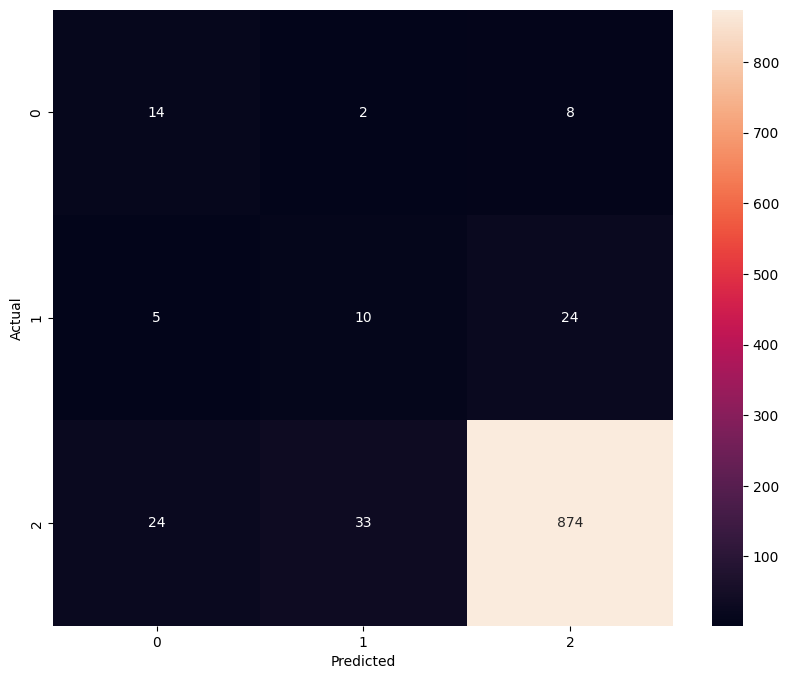

              precision    recall  f1-score   support

           0       0.33      0.58      0.42        24
           1       0.22      0.26      0.24        39
           2       0.96      0.94      0.95       931

    accuracy                           0.90       994
   macro avg       0.50      0.59      0.54       994
weighted avg       0.92      0.90      0.91       994



In [337]:
# Define GRU Model
gru_model = Sequential(name="GRU_Model") 
gru_model.add(Embedding(len(tokenizer.word_index)+1,  
                    max_words,  
                    input_length=max_words)) 
# adding a LSTM layer  
gru_model.add(Bidirectional(GRU(50, return_sequences=False)))
BatchNormalization() 
gru_model.add(Dropout(0.6)) 
#adding a dense layer with activation function of relu 
gru_model.add(Dense(50, activation='relu')) 
BatchNormalization() 
gru_model.add(Dropout(0.6)) 
# adding the final output activation with activation function of softmax 
gru_model.add(Dense(3, activation='softmax')) 
  
# printing model summary 
print(gru_model.summary())

# Compiling the model 
gru_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=[tf.keras.metrics.CategoricalAccuracy()]) 

# Training the GRU model 
history = gru_model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(X_test, y_test), callbacks=es, sample_weight=sample_weights) 
  
# Printing model score on test data 
print("GRU model Score---> ", gru_model.evaluate(XV, yV, verbose=1))

# converting y_test tht was one hot encoded to one column fo rconfusion matrix 
y_true = np.argmax(yV.values, axis=1) 
y_true.shape 
  
# Confusion matrix 
y_pred = np.argmax(gru_model.predict(XV), axis=1) 
cm = tf.math.confusion_matrix(y_true, y_pred) 
    
# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

report = classification_report(y_true, y_pred) 
print(report)

Topic Modeling:
We cluster similar reviews by using creating 5 clusters named topics 1 to 5. we use cont vectorizer to get the counts for each word and then pass it through a LDA and NMF for Topic Modeling. We then assign each review sample to a cluster and add this to main dataframe.


In [338]:
# Use CountVectorizer for LDA and NMF
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features=5000)
X_counts = count_vectorizer.fit_transform(CleanIdata['reviews.text'].fillna(''))

# Perform LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_model.fit_transform(X_counts)

# Display the topics for LDA
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("LDA Topics:")
display_topics(lda_model, count_vectorizer.get_feature_names_out(), 10)

# Assign each review to the most likely topic for LDA
lda_topic_assignments = np.argmax(lda_topics, axis=1)
CleanIdata['LDA_Topic'] = lda_topic_assignments
print(CleanIdata)

# Perform NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_topics = nmf_model.fit_transform(X_counts)

# Display the topics for NMF
print("NMF Topics:")
display_topics(nmf_model, count_vectorizer.get_feature_names_out(), 10)

# Assign each review to the most likely topic for NMF
nmf_topic_assignments = np.argmax(nmf_topics, axis=1)
CleanIdata['NMF_Topic'] = nmf_topic_assignments
print(CleanIdata)

LDA Topics:
Topic 0:
tablet good easy use great apps games amazon play kindle
Topic 1:
great tablet kids loves bought price gift love old kindle
Topic 2:
kindle great reading tablet books device love amazon screen read
Topic 3:
use easy good great product like sound nice love tap
Topic 4:
echo great love alexa music home amazon product plus fun
                                                   name   brand  \
0     All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...  Amazon   
1           Amazon - Echo Plus w/ Built-In Hub - Silver  Amazon   
2     Amazon Echo Show Alexa-enabled Bluetooth Speak...  Amazon   
3     Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...  Amazon   
4     Brand New Amazon Kindle Fire 16gb 7" Ips Displ...  Amazon   
...                                                 ...     ...   
3927        Amazon - Echo Plus w/ Built-In Hub - Silver  Amazon   
3928  Amazon Kindle E-Reader 6" Wifi (8th Generation...  Amazon   
3929  Amazon Tap - Alexa-Enabled Portable Bluetoot